In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Task 1 - Fourier Transform

In [2]:
def get_convolution_using_fourier_transform(image, kernel):

    # Calculate the Fourier transforms of the image and kernel
    ft_img = np.fft.fft2(image)
    ft_kernel = np.fft.fft2(kernel, s=image.shape)

    # Perform frequency domain multiplication
    ft_result = ft_img * ft_kernel

    # Transform the result back to the spatial domain
    result = np.fft.ifft2(ft_result).real  # .real extracts the real part

    # Normalize and convert the result to uint8
    result = (result - result.min()) / (result.max() - result.min()) * 255
    return result.astype(np.uint8)

In [3]:
def get_convolution_using_fourier_transform_correction(image, kernel):
    # Calculate the Fourier transforms of the image and kernel
    ft_image = np.fft.fft2(image)
    ft_kernel = np.fft.fft2(kernel, s=image.shape)

    # Perform frequency domain multiplication
    ft_result = ft_image * ft_kernel

    # Transform the result back to the spatial domain
    result = np.fft.ifft2(ft_result).real  # .real extracts the real part

    # Ensure the result is within the valid data range (0-255)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

In [4]:
def convolution_spatial_vectorized(image, kernel):
    k_height, k_width = kernel.shape
    k_center_x, k_center_y = k_width // 2, k_height // 2

    # Pad the image to handle borders
    padded_image = np.pad(image, ((k_center_y, k_center_y), (k_center_x, k_center_x)), mode='constant')

    # Perform convolution using vectorized operations
    result = np.zeros_like(image, dtype=np.float32)

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            result[y, x] = np.sum(padded_image[y:y + k_height, x:x + k_width] * kernel)

    # Normalize the result to be within the 0-255 range
    result = (result - np.min(result)) / (np.max(result) - np.min(result)) * 255

    return result.astype(np.uint8)

In [5]:
def get_convolution(image, kernel): 

    result = cv2.filter2D(image, -1, kernel) 
    return result

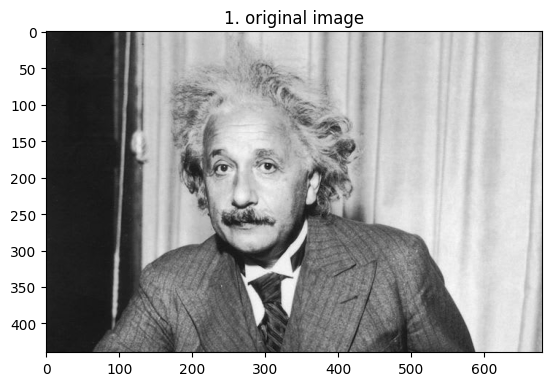

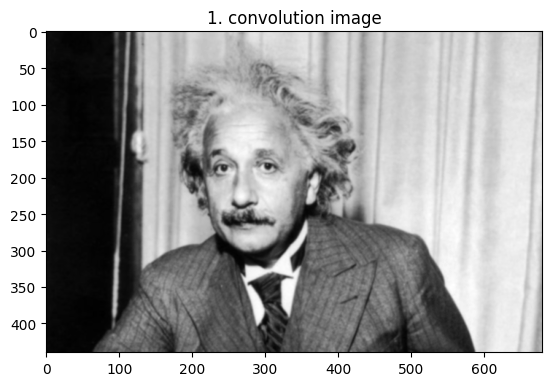

In [6]:
image = cv2.imread("./data/einstein.jpeg", cv2.IMREAD_GRAYSCALE)
kernel = cv2.getGaussianKernel(7,1)  
gaussian_kernel = kernel.dot(kernel.reshape(1, 7)) 
conv_result = get_convolution(image, gaussian_kernel)  
own_conv = convolution_spatial_vectorized(image,kernel)
fft_result = get_convolution_using_fourier_transform(image,kernel) 
fft_result_correction = get_convolution_using_fourier_transform_correction(image,kernel)

#plotting the five images

plt.title("1. original image")
plt.imshow(image, cmap="gray")
plt.show()

plt.title("1. convolution image")
plt.imshow(conv_result, cmap="gray")
plt.show()


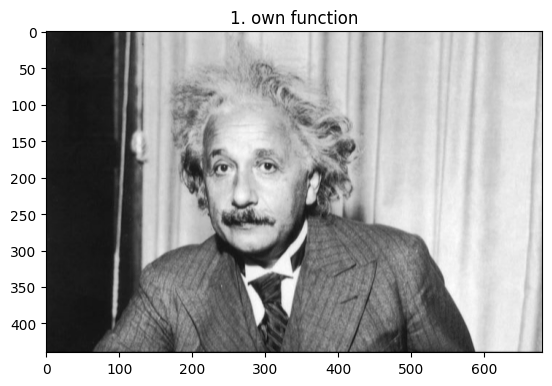

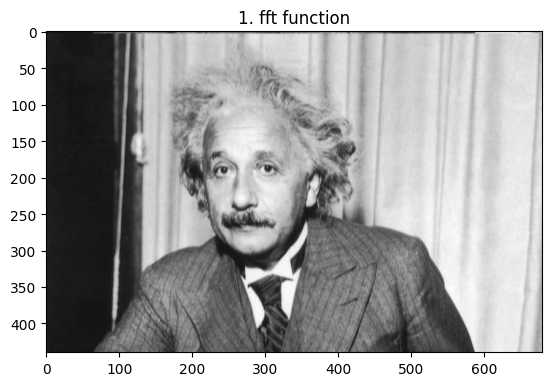

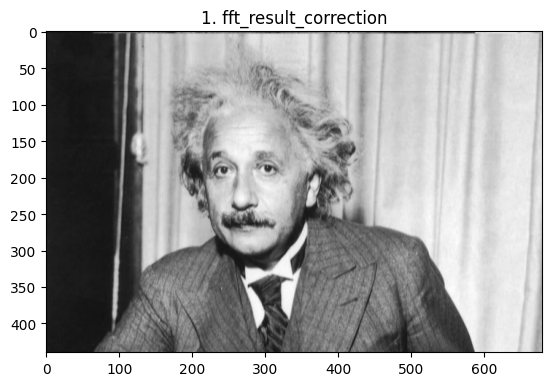

1. mean Absolute Difference:  12.262633689839571


In [7]:
plt.title("1. own function")
plt.imshow(own_conv, cmap="gray")
plt.show()

plt.title("1. fft function")
plt.imshow(fft_result, cmap="gray")
plt.show()

plt.title("1. fft_result_correction")
plt.imshow(fft_result_correction, cmap="gray")
plt.show()

mean_abs_diff = np.mean(np.abs(np.subtract(conv_result.astype(np.int32), fft_result.astype(np.int32))))
print("1. mean Absolute Difference: ", mean_abs_diff)


# Task 2 - Template Matching

In [8]:
def normalized_cross_correlation(image, template):
    k, l = template.shape
    n_rows = image.shape[0] - k + 1 
    n_cols = image.shape[1] - l + 1

    normalized_cross_correlation = np.zeros((n_rows, n_cols))

    xcorr_template = template - np.mean(template)
    sum_norm_template = np.sum(xcorr_template ** 2)

    for row in range(n_rows):
        for col in range(n_cols):
            image_patch = image[row:row + k, col:col + l]
            xcorr_image = image_patch - np.mean(image_patch)

            normalized_cross_correlation[row, col] = np.sum(xcorr_template * xcorr_image) / np.sqrt(sum_norm_template * np.sum(xcorr_image ** 2))

    return normalized_cross_correlation


def ssd(image, template): # measuring normalized square sum difference
    k, l = template.shape
    n_rows = image.shape[0] - k + 1
    n_cols = image.shape[1] - l + 1

    ssd = np.zeros((n_rows, n_cols))

    for row in range(n_rows):
        for col in range(n_cols):
            image_patch = image[row:row + k, col:col + l]
            ssd[row, col] = np.sum((template - image_patch) ** 2)

    return ssd 

def draw_rectangle_at_matches(image, template_h, template_w, matches):
    image_copy = image.copy()

    for row in range(matches.shape[0]):
        for col in range(matches.shape[1]):
            if matches[row, col]:
                cv2.rectangle(image_copy, (col, row), (col + template_w, row + template_h), (0,0, 255), 1)

    return image_copy

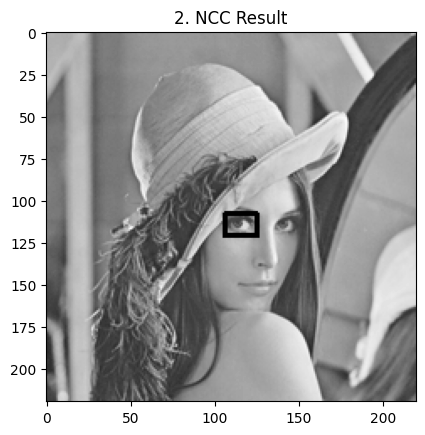

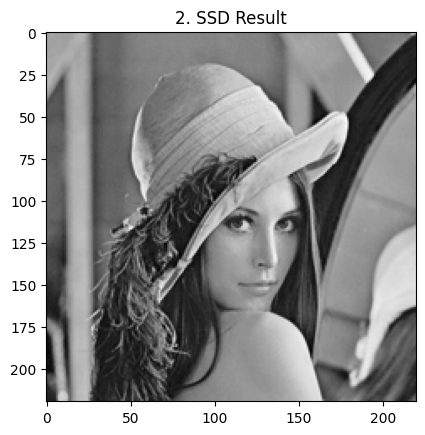

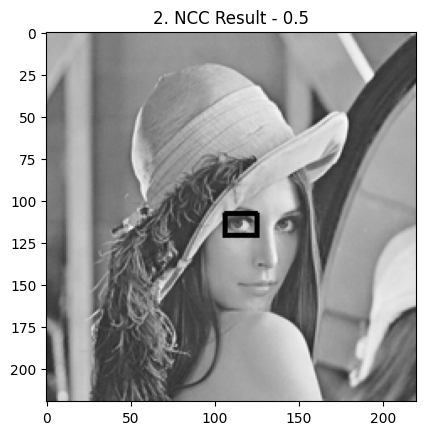

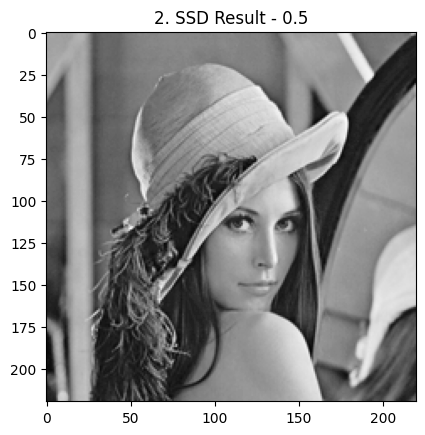

In [9]:
image = cv2.imread("./data/lena.png", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/eye.png", cv2.IMREAD_GRAYSCALE)

# convert to float and apply intensity transformation to image and template
result_ncc = normalized_cross_correlation(image, template)
result_ssd = ssd(image, template)

# drawing rectangles around matches where similarity <= 0.1 for SSD and >= 0.7 for NCC using np.where
matches_ncc = np.where(result_ncc >= 0.7, 1, 0) 
matches_ssd = np.where(result_ssd <= 0.1, 1, 0)

# drawing rectangles around matches where similarity <= 0.1 for SSD and >= 0.7 for NCC using np.where
image_ncc = draw_rectangle_at_matches(image, template.shape[0], template.shape[1], matches_ncc)
image_ssd = draw_rectangle_at_matches(image, template.shape[0], template.shape[1], matches_ssd)

# display results
plt.title("2. NCC Result")
plt.imshow(image_ncc, cmap="gray")
plt.show()

plt.title("2. SSD Result")
plt.imshow(image_ssd, cmap="gray")
plt.show()

# subtracting 0.5 to the image, making sure the values do not become negative,
#  and repeating the template matching 
image = image.astype(np.float32) - 0.5
image[image < 0] = 0
result_ncc = normalized_cross_correlation(image, template)
result_ssd = ssd(image, template)

# drawing rectangles around matches where similarity <= 0.1 for SSD and >= 0.7 for NCC using np.where
matches_ncc = np.where(result_ncc >= 0.7, 1, 0)
matches_ssd = np.where(result_ssd <= 0.1, 1, 0)

# drawing rectangles around matches where similarity <= 0.1 for SSD and >= 0.7 for NCC using np.where
new_image_ncc = draw_rectangle_at_matches(image, template.shape[0], template.shape[1], matches_ncc)
new_image_ssd = draw_rectangle_at_matches(image, template.shape[0], template.shape[1], matches_ssd)

# display results
plt.title("2. NCC Result - 0.5")
plt.imshow(new_image_ncc, cmap="gray")
plt.show()

plt.title("2. SSD Result - 0.5")
plt.imshow(new_image_ssd, cmap="gray")
plt.show()

When I performed the subtraction of 0.5 to the image, making sure the values do not become negative, and repeating the template matching, the results were not as good as the first one.  The reason is might be that the image is not normalized anymore, so the values are not in the range [0,1].

# Task 3 - Gaussian Pyramid

In [10]:
def build_gaussian_pyramid_opencv(image, num_levels):
    
    pyramid = [image]
    for _ in range(num_levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def custom_pyrDown(image):
    kernel = cv2.getGaussianKernel(3, 1)
    kernel = kernel.dot(kernel.T)
    # Convolve the image with the Gaussian kernel
    blurred = cv2.filter2D(image, -1, kernel)
    # Down-sample by selecting every second pixel
    downsampled = blurred[::2, ::2]

    return downsampled

def build_gaussian_pyramid(image, num_levels):
    
    """ 
    own function for gaussian pyramid
    """
    pyramid = [image]
    for _ in range(num_levels):
        image = custom_pyrDown(image)
        pyramid.append(image)
    return pyramid 


def template_matching_multiple_scales(pyramid_image, pyramid_template, threshold):
    results = []
    level = len(pyramid_image)
    print("# of Level:", level)

    for idx in range(0, level):
        refimg = pyramid_image[-idx]
        tplimg = pyramid_template[-idx]

        # Perform template matching
        result = cv2.matchTemplate(refimg, tplimg, cv2.TM_CCORR_NORMED)

        if idx > 0:
            # Calculate mask for the pyramid level
            mask = cv2.pyrUp(results[-1])
            T, mask = cv2.threshold(mask, threshold, 1.0, cv2.THRESH_BINARY)

            # Use binary thresholding to convert to 0s and 1s
            mask = (mask > 0).astype(np.float32)

            # Create a mask that reflects the size of the template
            mask_template = cv2.matchTemplate(refimg, tplimg, cv2.TM_CCORR_NORMED)
            mask_template = (mask_template > threshold).astype(np.float32)

            if mask.shape != result.shape:
                mask = cv2.resize(mask, (result.shape[1], result.shape[0]))

            # Apply the masks
            mask *= mask_template
            result *= mask

        results.append(result)

    return results

In [11]:
# Load the image and template
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("./data/traffic-template.png", cv2.IMREAD_GRAYSCALE)

my_pyramid = build_gaussian_pyramid(image, 4)
cv_pyramid = build_gaussian_pyramid_opencv(image, 4)

for x, (cv_img, custom_img) in enumerate(zip(cv_pyramid, my_pyramid)):
    diff = np.mean(np.abs(cv_img - custom_img))
    print(f'3. Mean abs difference: level {x}: {diff:.2f}')

start_time = time.time()
result = normalized_cross_correlation(image, template)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"3. Time taken for NCC: {elapsed_time:.4f} seconds")

pyramid_template = build_gaussian_pyramid(template, 4)
start_time_pyramid = time.time()
result_pyramid = template_matching_multiple_scales(my_pyramid, pyramid_template, 0.5)
end_time_pyramid = time.time()
elapsed_time_pyramid = end_time_pyramid - start_time_pyramid
print(f"3. Time taken for NCC with pyramid: {elapsed_time_pyramid:.4f} seconds")

3. Mean abs difference: level 0: 0.00
3. Mean abs difference: level 1: 95.07
3. Mean abs difference: level 2: 101.93
3. Mean abs difference: level 3: 106.53
3. Mean abs difference: level 4: 109.88
3. Time taken for NCC: 25.7680 seconds
# of Level: 5
3. Time taken for NCC with pyramid: 0.0410 seconds


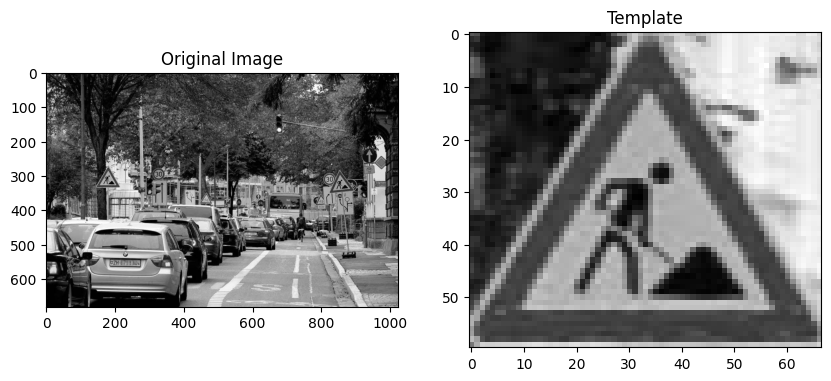

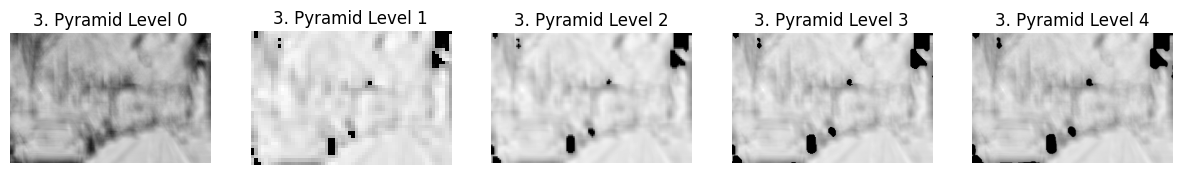

In [12]:
# showing the template matching results using the pyramid approach

# plotting the original image and the template in a single figure
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Template")
plt.imshow(template, cmap="gray")
plt.show()

# plotting the template matching results using the pyramid approach in a single figure
fig, axes = plt.subplots(1, len(result_pyramid), figsize=(15, 5))

for idx, result in enumerate(result_pyramid):
    axes[idx].set_title(f"3. Pyramid Level {idx}")
    axes[idx].imshow(result, cmap="gray")
    axes[idx].axis('off')  # Optional: Turn off axis labels if needed

plt.show()

# Task 4 - Edges

In [13]:
def get_derivative_of_gaussian_kernel(size, sigma):
    kernel = cv2.getGaussianKernel(size, sigma)
    kernel_2D = kernel.dot(kernel.reshape(1, size)) 
    dx, dy = np.gradient(kernel_2D)
    print("4. Weights of derivative of gaussian kernel in X direction")
    print(dx)
    print("4. Weights of derivative of gaussian kernel in Y direction")
    print(dy)
    return dx, dy

def non_max_suppression(gradient_magnitude, gradient_direction):
    m, n = gradient_magnitude.shape
    resulting_image = np.zeros((m, n), dtype=np.float32)
    angle = gradient_direction * 180.
    angle[angle < 0] += 180

    for i in range (1, m-1):
        for j in range (1, n-1):
            q = 255
            r = 255

            #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            if (gradient_magnitude[i,j] >= q) and (gradient_magnitude[i,j] >= r):
                resulting_image[i,j] = gradient_magnitude[i,j]
            else:
                resulting_image[i,j] = 0

    return resulting_image

def thresholding(image, low, high):
    m, n = image.shape
    result = np.zeros((m,n), dtype=np.float32)

    for i in range(1, m-1):
        for j in range(1, n-1):
            if image[i,j] > high:
                result[i,j] = 255
            elif image[i,j] < low:
                result[i,j] = 0
            else:
                result[i,j] = image[i,j]
    return result

Derivative of gaussian

4. Weights of derivative of gaussian kernel in X direction
[[ 0.00427379  0.0079845   0.01161738  0.01316421  0.01161738  0.0079845
   0.00427379]
 [ 0.00422898  0.00790077  0.01149555  0.01302616  0.01149555  0.00790077
   0.00422898]
 [ 0.00298286  0.00557272  0.00810826  0.00918786  0.00810826  0.00557272
   0.00298286]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [-0.00298286 -0.00557272 -0.00810826 -0.00918786 -0.00810826 -0.00557272
  -0.00298286]
 [-0.00422898 -0.00790077 -0.01149555 -0.01302616 -0.01149555 -0.00790077
  -0.00422898]
 [-0.00427379 -0.0079845  -0.01161738 -0.01316421 -0.01161738 -0.0079845
  -0.00427379]]
4. Weights of derivative of gaussian kernel in Y direction
[[ 0.00427379  0.00422898  0.00298286  0.         -0.00298286 -0.00422898
  -0.00427379]
 [ 0.0079845   0.00790077  0.00557272  0.         -0.00557272 -0.00790077
  -0.0079845 ]
 [ 0.01161738  0.01149555  0.00810826  0.         -0.00810826 -0.01149555
  -0.01161738]
 

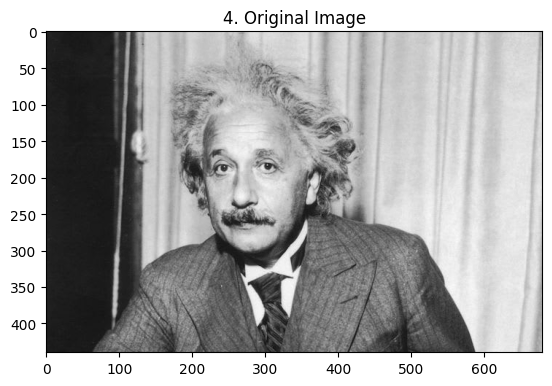

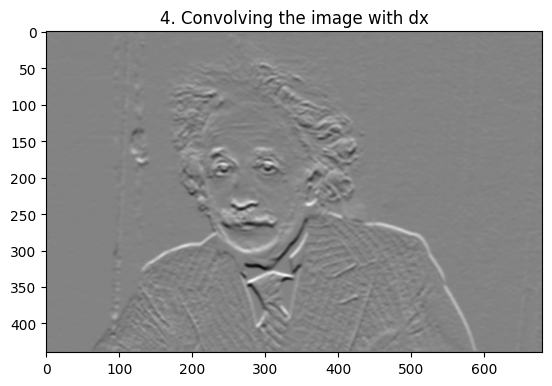

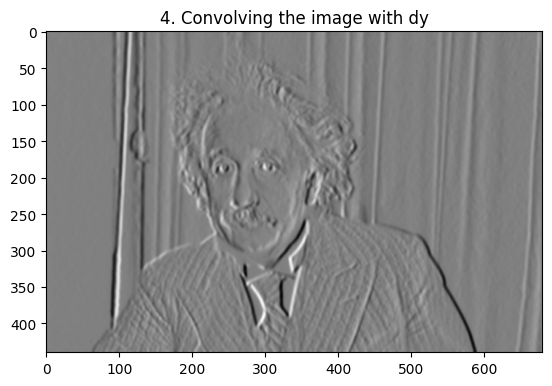

In [14]:
image = cv2.imread("./data/einstein.jpeg", cv2.IMREAD_GRAYSCALE)

kernel_x, kernel_y = get_derivative_of_gaussian_kernel(7, 2)

# convolve the image with Gaussian kernels
edges_x = cv2.filter2D(image.astype(np.float32), -1, kernel_x)
edges_y = cv2.filter2D(image.astype(np.float32), -1, kernel_y)

plt.title("4. Original Image")
plt.imshow(image, cmap="gray")
plt.show()

plt.title("4. Convolving the image with dx")
plt.imshow(edges_x, cmap="gray")
plt.show()

plt.title("4. Convolving the image with dy")
plt.imshow(edges_y, cmap="gray")
plt.show()


4. Magnitude:  [[1.7505397e-07 2.6469573e-02 8.8130757e-02 ... 4.4172487e+00
  2.3141265e+00 5.5670972e-07]
 [1.9931895e-01 2.0623018e-01 2.2054118e-01 ... 4.3137183e+00
  2.2749679e+00 4.5397004e-01]
 [3.6227745e-01 3.7247139e-01 3.7481475e-01 ... 4.0096097e+00
  2.1053927e+00 6.3980311e-01]
 ...
 [1.8568362e-01 1.7879076e-01 1.4410321e-01 ... 3.7171545e+00
  2.3250470e+00 1.1382673e-01]
 [1.0418670e-01 9.9829078e-02 7.3854305e-02 ... 3.9482007e+00
  2.4691594e+00 2.3828292e-01]
 [1.5244132e-07 1.7005457e-02 9.8069739e-03 ... 4.0480113e+00
  2.5200760e+00 2.9524247e-07]]
4. Direction:  [[ 1.0285521e+00  1.5708035e+00 -1.5707963e+00 ...  1.5707954e+00
   1.5707965e+00 -1.3720884e+00]
 [ 1.0116015e-06  1.5304957e-01 -4.1924465e-01 ...  1.6181475e+00
   1.7411631e+00  3.1415915e+00]
 [-8.2263810e-08  1.4240108e-01 -2.1452083e-01 ...  1.6274832e+00
   1.8234133e+00 -3.1415925e+00]
 ...
 [-2.5078211e-07  2.8625628e-01  4.9897361e-01 ... -1.5084376e+00
  -1.5793387e+00 -3.1415918e+00]
 [-1.

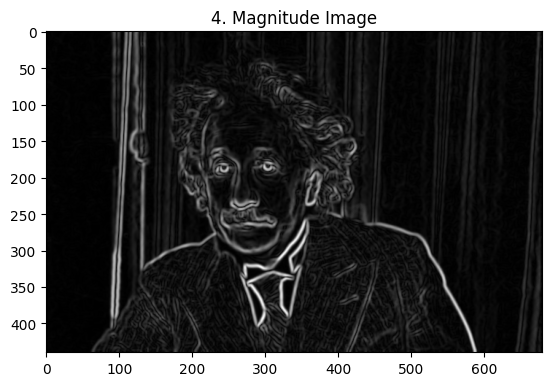

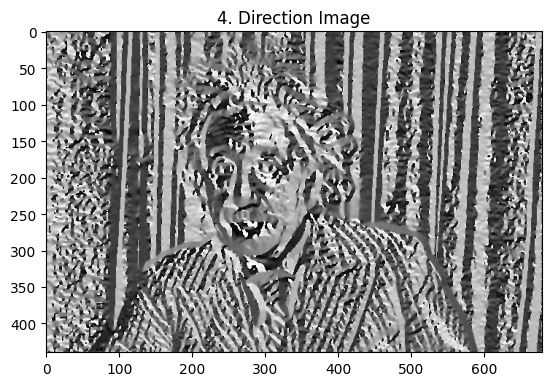

In [15]:
# computing the edge magnitude
magnitude = np.sqrt(edges_x ** 2 + edges_y ** 2)
# computing the edge direction
direction = np.arctan2(edges_y, edges_x)
print("4. Magnitude: ", magnitude)
print("4. Direction: ", direction)

plt.title("4. Magnitude Image")
plt.imshow(magnitude, cmap="gray")
plt.show()

plt.title("4. Direction Image")
plt.imshow(direction, cmap="gray")
plt.show()


4. Suppressed Image:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


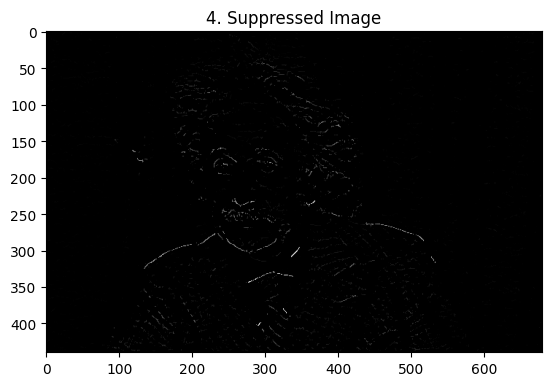

4. Low Threshold:  2.9289730072021487
4. High Threshold:  26.360757064819335
4. Threshold Image:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


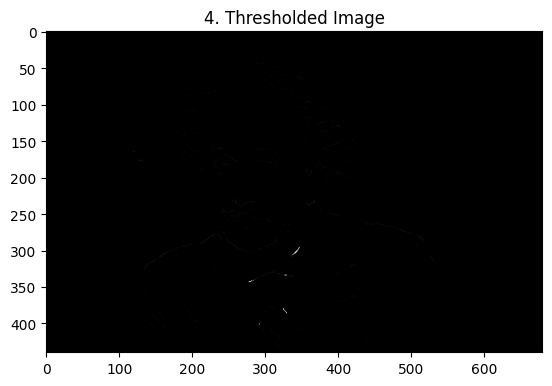

In [16]:
suppressed_image = non_max_suppression(magnitude, direction)
print("4. Suppressed Image: ", suppressed_image)
plt.title("4. Suppressed Image")
plt.imshow(suppressed_image, cmap="gray")
plt.show()

# applying thresholding
low = 0.1 * np.max(suppressed_image)
high = 0.9 * np.max(suppressed_image)
print("4. Low Threshold: ", low)
print("4. High Threshold: ", high)
threshold_image = thresholding(suppressed_image, low, high)
print("4. Threshold Image: ", threshold_image)

plt.title("4. Thresholded Image")
plt.imshow(threshold_image, cmap="gray")
plt.show()

Sobel

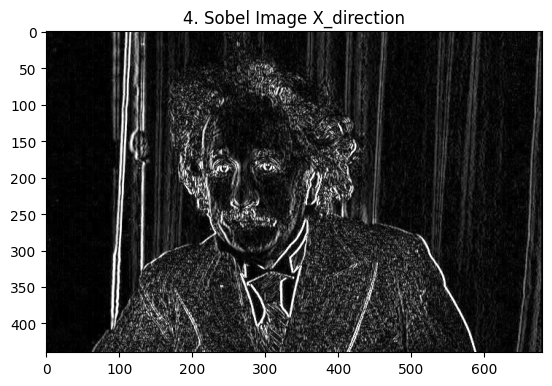

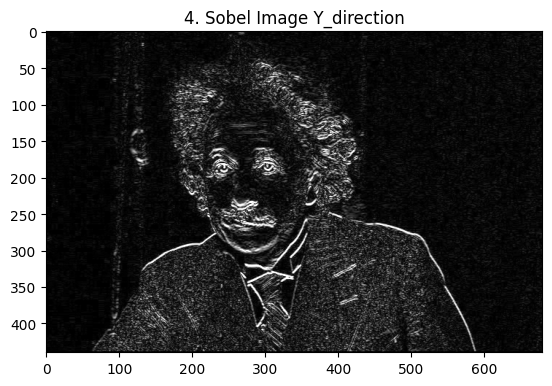

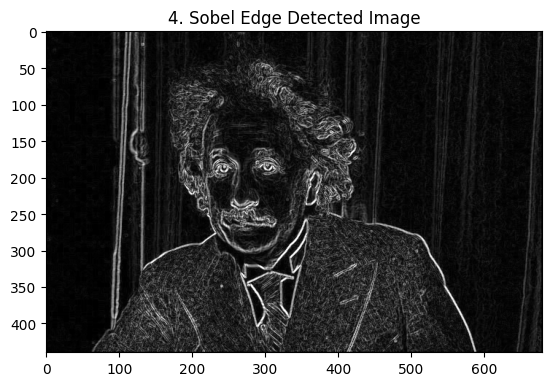

4. Mean Absolute Error:  28.421042780748664


In [17]:
# Sobel
kernel_size = 3
sobel_kernel_x, sobel_kernel_y = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size), cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)

edge_sobel_x = cv2.convertScaleAbs(sobel_kernel_x)
edge_sobel_y = cv2.convertScaleAbs(sobel_kernel_y)
magnitude_sobel = np.sqrt(edge_sobel_x ** 2 + edge_sobel_y ** 2)

plt.title("4. Sobel Image X_direction")
plt.imshow(edge_sobel_x, cmap="gray")
plt.show()

plt.title("4. Sobel Image Y_direction")
plt.imshow(edge_sobel_y, cmap="gray")
plt.show()

sobel_edge_detected = cv2.addWeighted(edge_sobel_x, 0.5, edge_sobel_y, 0.5, 0)
plt.title("4. Sobel Edge Detected Image")
plt.imshow(sobel_edge_detected, cmap="gray")
plt.show()
# computing the mean absolute error
mean_abs_error = np.mean(np.abs(np.subtract(sobel_edge_detected.astype(np.int32), threshold_image.astype(np.int32))))
print("4. Mean Absolute Error: ", mean_abs_error)

# Task 5 - Distance Transform

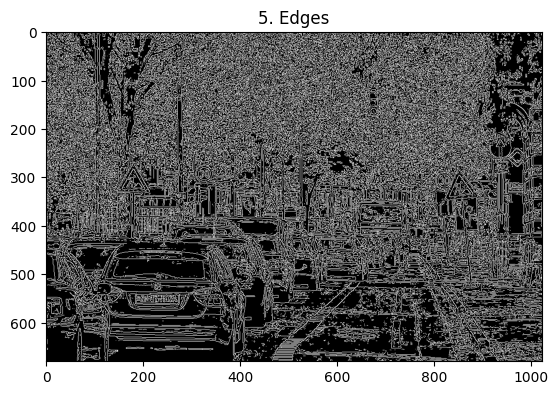

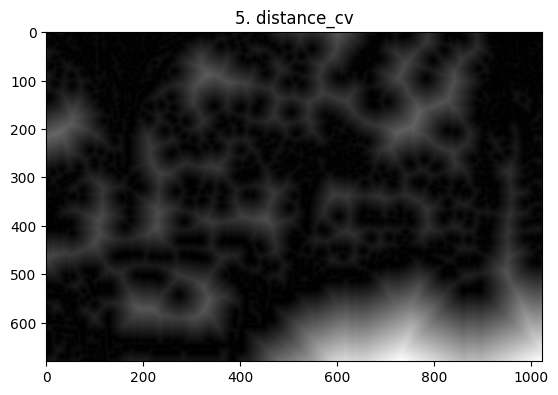

5. distance_cv:  [[  2.324295     1.3692932    0.95500183 ...   1.3692932    2.324295
    2.7385864 ]
 [  1.9100037    0.95500183   0.         ...   0.95500183   1.3692932
    2.324295  ]
 [  2.324295     1.3692932    0.95500183 ...   0.           0.95500183
    1.9100037 ]
 ...
 [ 13.370026    13.370026    13.370026   ... 186.44168    186.85597
  187.27026   ]
 [ 14.325027    14.325027    14.325027   ... 187.39668    187.81097
  188.22527   ]
 [ 15.280029    15.280029    15.280029   ... 188.35168    188.76598
  189.18027   ]]


In [18]:
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(image, 50, 60)

plt.title("5. Edges")
plt.imshow(edges, cmap="gray") 
plt.show()

dist_transfom_cv = cv2.distanceTransform(image, cv2.DIST_L2, 3)

plt.title("5. distance_cv")
plt.imshow(dist_transfom_cv, cmap="gray")
plt.show()

print("5. distance_cv: ", dist_transfom_cv)